<a href="https://colab.research.google.com/github/Tochi-O/tensorflow/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlowPart 2: Fine-tuning

In the previous notrbook, we covered transfer learning feature extraction now its time to learn about a new king of transfer learning: fine-tuning.


In [ ]:
#Check if we're using a GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Creating helper functions

In previous notebooks we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere)

We've done this for some of the functions we've used previously here: 
https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py



In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2021-10-29 10:52:09--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-29 10:52:09 (84.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves,unzip_data,walk_through_dir


**Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models within tf.keras. apply them to our own problem (recognizing images of food)
link: https://www.tensorflow.org/api_docs/python/tf/keras/applications



In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2021-10-29 10:52:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   185MB/s    in 0.9s    

2021-10-29 10:52:13 (185 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
#checck out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE= 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [ ]:
#Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[2.44770416e+02 2.45770416e+02 2.39770416e+02]
   [2.34311218e+02 2.35311218e+02 2.29311218e+02]
   [2.40433670e+02 2.41647964e+02 2.36647964e+02]
   ...
   [2.43852020e+02 2.43852020e+02 2.43852020e+02]
   [2.44571396e+02 2.44571396e+02 2.42571396e+02]
   [2.48158493e+02 2.48158493e+02 2.46158493e+02]]

  [[2.45000000e+02 2.46000000e+02 2.40000000e+02]
   [2.35709198e+02 2.36709198e+02 2.30709198e+02]
   [2.38943878e+02 2.40158157e+02 2.35158157e+02]
   ...
   [2.41285690e+02 2.41285690e+02 2.41285690e+02]
   [2.41928543e+02 2.41928543e+02 2.39928543e+02]
   [2.46214600e+02 2.46214600e+02 2.44214600e+02]]

  [[2.45142868e+02 2.46000000e+02 2.41357147e+02]
   [2.34285721e+02 2.35500015e+02 2.30500015e+02]
   [2.38357147e+02 2.39311234e+02 2.34448990e+02]
   ...
   [2.41428528e+02 2.41428528e+02 2.41428528e+02]
   [2.41658142e+02 2.41658142e+02 2.39658142e+02]
   [2.46571777e+02 2.46571777e+02 2.44571777e+02]]

  ...

  [[2.46857147e+02 2.47857147e+02 2.41857147e+02]
   [2

## Model 0: Building a transfer learning model using the keras functional api

the sequential api is straigtforward, it runs our layers in seqential order.

But the functional API gives us more flexibility with our models.

In [ ]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

#2. Freeze the base model (so the underlying pretrained pateerna arent updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

#4. If using a model like resnet50v2 you will need to normalize inputs (dont have to for efficient net)
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5. pass inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

#6. average pool outputs of base model (aggregate all the most important information)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after globalaveragepooling2d: {x.shape}")

#7. output activation laye
outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

#8. combinr the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

#9. compile for the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#10. fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 *len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])


16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after globalaveragepooling2d: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20211029-105221
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 87s 3s/step - loss: 1.9742 - accuracy: 0.3600 - val_loss: 1.4107 - val_accuracy: 0.6924
Epoch 2/5
24/24 [==============================] - 67s 3s/step - loss: 1.1850 - accuracy: 0.7427 - val_loss: 0.9743 - val_accuracy: 0.8026
Epoch 3/5
24/24 [==============================] - 78s 3s/step - loss: 0.8661 - accuracy: 0.8027 - val_loss: 0.7892 - val_accuracy: 0.8076
Epoch 4/5
24/24 [==============================] - 77s 3s/step - loss: 0.7021 - accuracy: 0.8493 - val_loss: 0.6694 - val_accuracy: 0.8273
Epoch 5/5
24/24 [==============================] - 79s 3s/step - loss: 0.6102 - accuracy: 0.8640 - val_loss: 0.6181 - val_accuracy: 0.8273


In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 122s 2s/step - loss: 0.6199 - accuracy: 0.8360


[0.6199347376823425, 0.8360000252723694]

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


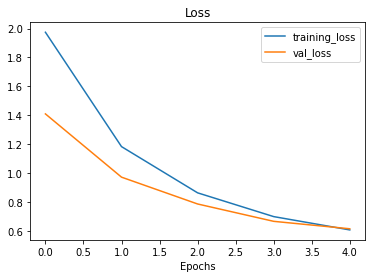

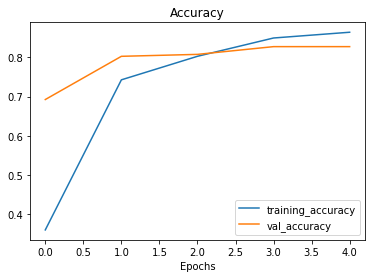

In [ ]:
#loss curve
plot_loss_curves(history_10_percent)

## Get feature model from trained model
lets deonstrate  the gloabal average pooling 2d layer
we have a tensor after our doel goes through `bse_model` of hsape (none,7,7,1280)
nut them wehen it passes through gap2d it turns to (none,1280)
lets use a similar shaped tensor of (1,4,4,3) and pass it to gap2d

In [ ]:
#define the input shape
input_shape = (1,4,4,3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"random input tensor:\n{input_tensor}\n")

#pass the random tensor throgh a global average pooling 2d layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global avaerage pooled random tensor :\n {global_average_pooled_tensor}\n")

#check the shape 
print(f"shape of input tensor: {input_tensor.shape}")
print(f"shape of golabal average pooled 2d  tensor: {global_average_pooled_tensor.shape}")


random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global avaerage pooled random tensor :
 [[-0.09368646 -0.45840445 -0.28855976]]

shape of input tensor: (1, 4, 4, 3)
shape of golabal average pooled 2d  tensor: (1, 3)


In [ ]:
#lets replicate the gloalavaeagepool2d 
tf.reduce_mean(input_tensor,axis=[1,2])


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

**practice:** same with above 2 cells use maxppool2d

## Runnong a series of transfer learning experiments\
1. `model_1` - use feature extraction transfer learning with 1% of the training data
2. ''model_2 - use feature extarction transfer learning with 10% of the training with data augmentation
3. `model_3`- fire tuning on 10% of the training data with augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the trainig data on 100% 

same test dataset will be used to evaluate our model this ensure consistent evaluation metrics


###getting and preprocessing data for mdoel 1

In [ ]:
#download and unzip data - preprocessed from food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")


--2021-10-29 11:01:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   133MB/s    in 1.0s    

2021-10-29 11:01:16 (133 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
#create traininng and test dirs

train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
#how many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There a

In [ ]:
IMG_SIZE =(224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1_percent,label_mode="categorical",image_size=IMG_SIZE
    ,batch_size=32) #default=32

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,label_mode="categorical",image_size=IMG_SIZE
    ,batch_size=32) #default=32

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## adding data augmentation right into the model
to add data augmentatiob right into out models
we can use the laters inside

* tf.keras.layers.experimental.preprocessing()

we can see the benfits of doing this within the tensorflow data augmentation

https://www.tensorflow.org/tutorials/images/data_augmentation

off the top of our heads, after reading the docs, the benefits of using data augmentation inside the model are:
* preprocessing of images (augmenting them) happens on the gpu faster than thr cpu

* image data augmentaion only happens during training sp we can still export our whole model and use it elsewhere


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#create data augmentagion stage with hirizontal flipping, rotations zoom, etc
data_augmentation = keras.Sequential([
 preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
   preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
     preprocessing.RandomWidth(0.2),
     #preprocessing.Rescale(1./255) # Keep for models like resnet50v2 but efficientnet does it already
], name = "data_augmentation")


### Visualize our data augmentation layer (and see what happens to our data)

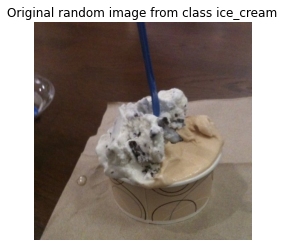

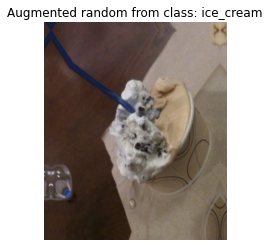

In [ ]:
#view a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
#print(img)
plt.axis(False);

#lets plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img,axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random from class: {target_class}")
plt.axis(False);


In [ ]:
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 1: feature extrcation transfer learning on 1% of the data with data augmentation

In [ ]:
# Setup input sape and ase model, freezing rhe base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape,name="input_layer")

# Add in data augmentation Sequential model
x = data_augmentation(inputs)

#Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

#Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10,activation="softmax",name="output_layer")(x)

# make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
#Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                #Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])




Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20211029-110124
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 54s 23s/step - loss: 2.4168 - accuracy: 0.1286 - val_loss: 2.2244 - val_accuracy: 0.1546
Epoch 2/5
3/3 [==============================] - 45s 21s/step - loss: 2.1568 - accuracy: 0.2571 - val_loss: 2.1078 - val_accuracy: 0.2451
Epoch 3/5
3/3 [==============================] - 44s 21s/step - loss: 1.9631 - accuracy: 0.4000 - val_loss: 1.9976 - val_accuracy: 0.3191
Epoch 4/5
3/3 [==============================] - 45s 22s/step - loss: 1.8258 - accuracy: 0.4714 - val_loss: 1.9204 - val_accuracy: 0.3684
Epoch 5/5
3/3 [==============================] - 45s 21s/step - loss: 1.7034 - accuracy: 0.5429 - val_loss: 1.8254 - val_accuracy: 0.4161


In [ ]:
#model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
#evaluate on full test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 139s 2s/step - loss: 1.8404 - accuracy: 0.3944


[1.8403855562210083, 0.3944000005722046]

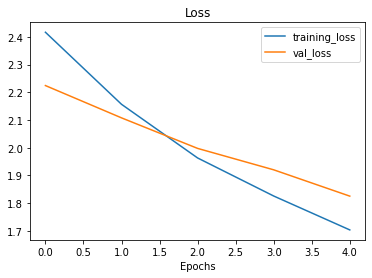

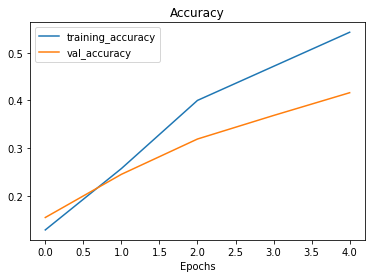

In [ ]:
# How does the model 1%of the data  augmentation loss curves look?
plot_loss_curves(history_1_percent)

## Model 2: feature exraction transfer learning model with 10% of data and data augmentation

In [ ]:
# Get 10% of data
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_daata(10_food_classes_)

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
walk_through_dir(train_dir_10_percent)

There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.


In [ ]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_10_percent,
    label_mode="categorical",
    image_size=IMG_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size= IMG_SIZE
)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# create modle 2 with data augmentaion built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  #preprocessing.Rescaling #if you use resnetv250 youll need to rescale but efficient net has rescalig built in
], name = "data_augmentation")

#setup the input shape to out model
input_shape = (224,224,3)

#create a frozen base model (also called tthe backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#create the inputs and outputs (includignthe layers in between)
inputs = layers.Input(shape=input_shape,name="input_layer")
x = data_augmentation(inputs) #augment training images (augmentation doesnt occur on test data)
x = base_model(x, training=False) #pass the augmented images to base modle but keep it it inference mode, this also insures batchnorm layers dont get updated https://keras.io/guides/transfer_learning
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)

outputs = layers.Dense(10,activation="softmax",name="output_layer")(x)
model_2 = tf.keras.Model(inputs,outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_2D (G (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


### creating a model checkpoint callback

The modelcheckpoint callback intermediately saves out model (the full model or just the weights) during training. This is usefu; so we can come and start where we left off.

In [ ]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a modelcheckpoint callback that saves the models weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                          save_weights_only=True,
                                                          save_best_only=False,
                                                          save_freq="epoch", # every epoch
                                                        verbose=1
                                                         )


##Fit model 2 passing in the ModelCheckpoint callback

In [ ]:
#fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20211029-110930
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 92s 4s/step - loss: 2.0111 - accuracy: 0.3493 - val_loss: 1.5060 - val_accuracy: 0.6234

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 88s 4s/step - loss: 1.3709 - accuracy: 0.6693 - val_loss: 1.0660 - val_accuracy: 0.7319

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 78s 3s/step - loss: 1.0865 - accuracy: 0.7200 - val_loss: 0.8873 - val_accuracy: 0.7632

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 80s 3s/step - loss: 0.9004 - accuracy: 0.7853 - val_loss: 0.7862 - val_accuracy: 0.7862

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 89s 4s/step - loss: 0.7950 - accuracy: 0.8013 - val_loss: 0.7232 - 

In [ ]:
#model_0 results
model_0.evaluate(test_data)

79/79 [==============================] - 148s 2s/step - loss: 0.6199 - accuracy: 0.8360


[0.6199345588684082, 0.8360000252723694]

In [ ]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 148s 2s/step - loss: 0.6979 - accuracy: 0.8040


[0.6979157328605652, 0.8040000200271606]

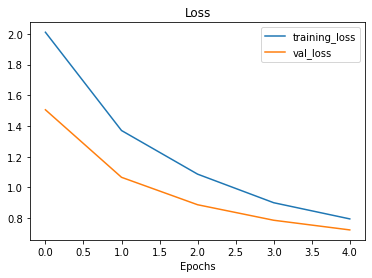

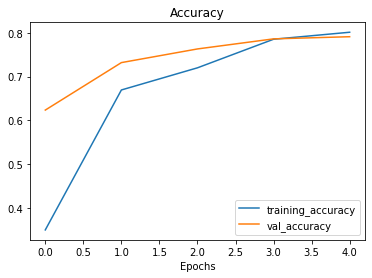

In [ ]:
#plot loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [ ]:
#Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
#evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 149s 2s/step - loss: 0.6979 - accuracy: 0.8040


In [ ]:
# if the results from our previouslt evaluates moel_2 match the loaded weights, everything has worked
results_10_percent_data_aug == loaded_weights_model_results

False

In [ ]:
results_10_percent_data_aug

[0.6979157328605652, 0.8040000200271606]

In [ ]:
loaded_weights_model_results

[0.6979156732559204, 0.8040000200271606]

In [ ]:
# chech to se if loaded model results are very close to out previous non-loaded model results

import numpy as np
np.isclose(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
#diffrence btween the wtwo results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[5.96046448e-08 0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

**Note:** fine tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.



In [ ]:
#layers in loaded model
model_2.layers

In [ ]:
# are these ayers trainable?
for layer in model_2.layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fd93f246d50> True
<keras.engine.sequential.Sequential object at 0x7fd93dc549d0> True
<keras.engine.functional.Functional object at 0x7fd93ed11a50> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fd93dd5ed50> True
<keras.layers.core.Dense object at 0x7fd944416510> True


In [ ]:
# what layers are in our base_model (efficientnetb0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)



0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
#To begin fine-tunind, lets start by setting the last 10 layers of our base_model.trainable = tru
base_model.trainable = True

#Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our mdoels every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #when fine-tuning you typically want to lower the learning rate by 10x
                metrics=["accuracy"])  

**note** when fine tuning its best to ower learning rate by some amount.How much? this is hyperparameter you can tube. But a good rule of thumb is at least 10x (though different sources will cliam other values)
good resource is ulmfit paper 
https://arxiv.org/abs/1801.06146

In [ ]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
#weve unfrozen some of the laters closer to the top, how many trainable layers are htere
print(len(model_2.trainable_variables))

12


In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs+5

#refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(
    train_data_10_percent,epochs=fine_tune_epochs,
    validation_data=test_data,validation_steps=int(0.25*len(test_data)),
    initial_epoch = history_10_percent_data_aug.epoch[-1], # start training from previous last epoch
    callbacks=[create_tensorboard_callback(
        dir_name="transfer_learning",
        experiment_name="10_percent_fine_tune_last_10"
    )]
)

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20211029-112555
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 102s 4s/step - loss: 0.6949 - accuracy: 0.7893 - val_loss: 0.5695 - val_accuracy: 0.7993
Epoch 6/10
24/24 [==============================] - 94s 4s/step - loss: 0.5643 - accuracy: 0.8307 - val_loss: 0.5409 - val_accuracy: 0.8158
Epoch 7/10
24/24 [==============================] - 91s 4s/step - loss: 0.5082 - accuracy: 0.8507 - val_loss: 0.5310 - val_accuracy: 0.8043
Epoch 8/10
24/24 [==============================] - 95s 4s/step - loss: 0.4363 - accuracy: 0.8613 - val_loss: 0.4961 - val_accuracy: 0.8273
Epoch 9/10
24/24 [==============================] - 94s 4s/step - loss: 0.4091 - accuracy: 0.8693 - val_loss: 0.4895 - val_accuracy: 0.8289
Epoch 10/10
24/24 [==============================] - 96s 4s/step - loss: 0.3800 - accuracy: 0.8800 - val_loss: 0.4830 - val_accuracy: 0.8306


In [ ]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 156s 2s/step - loss: 0.4882 - accuracy: 0.8320


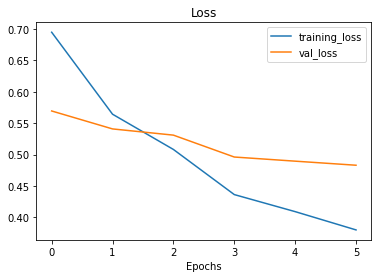

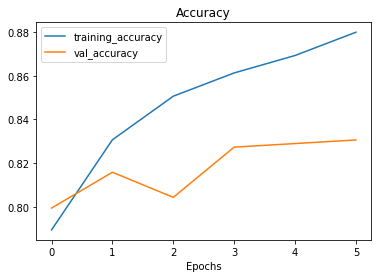

In [ ]:
# Check put the loss curves of our finetune model (model_3 which is actually model_2 fine-tuned for another)
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot loss curves ` function works great with model only fit once, howerver, we want something to compare one series of running `fit()`

In [ ]:
# Lets create a function to compare training histories

def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compares two Tensorflwo History objects.
  """
  # Get original history measurements.
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["accuracy"]
  total_val_loss = val_loss + new_history.history["loss"]
  

  #Make plots for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc,label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine Tuning")
  plt.legend(loc="lower right") 
  plt.title("Training and Validation Accuracy")

 #Make plots for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss,label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine Tuning")
  plt.legend(loc="upper right") 
  plt.title("Training and Validation Loss")


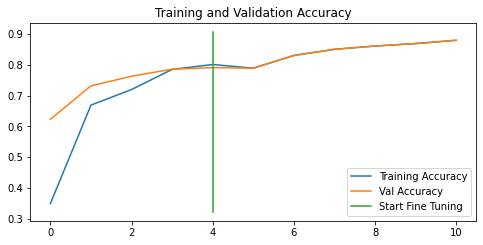

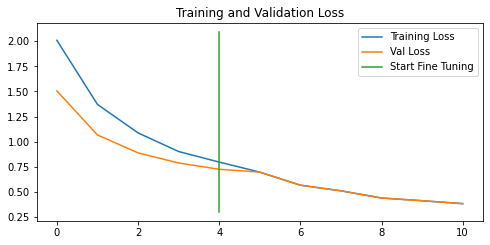

In [ ]:
compare_historys(
    history_10_percent_data_aug,
    history_fine_10_percent_data_aug,
    initial_epochs=5
)

## Model 4: Fine-tuning 

In [ ]:
#download and unzip 10 classes of FOOD101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2021-10-29 11:38:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 74.125.197.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   126MB/s    in 3.8s    

2021-10-29 11:38:55 (129 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir =  "10_food_classes_all_data/test"

In [ ]:
#How mant images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_all_data,
    label_mode="categorical",
    image_size=IMG_SIZE
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, label_mode="categorical",image_size=IMG_SIZE
)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for reviuos experiments (all experiments with this dataset)

Lets verify this

In [ ]:
# Evaluate model 2 (this is the fint-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 145s 2s/step - loss: 0.4882 - accuracy: 0.8320


[0.48816347122192383, 0.8320000171661377]

In [ ]:
results_fine_tune_10_percent

[0.4881635308265686, 0.8320000171661377]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights

In [ ]:
#Load weights from checkpoint, that way we can fine-tune from 
#the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)


In [ ]:
# Lets evaluate model 2 now
model_2.evaluate(test_data)


79/79 [==============================] - 146s 2s/step - loss: 0.6979 - accuracy: 0.8040


[0.6979156136512756, 0.8040000200271606]

In [ ]:
# check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6979157328605652, 0.8040000200271606]

Alright the previous steps might seem quite confuisng but all weve done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback

2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).

3. Saved the results and training logs each time.

4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_4).



In [ ]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [ ]:
# Lets drill into our base_model and see what layers are trainable

for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
#Compile
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [ ]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs+5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25*len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20211029-120630
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 583s 2s/step - loss: 0.5983 - accuracy: 0.8048 - val_loss: 0.3805 - val_accuracy: 0.8586
Epoch 6/10
235/235 [==============================] - 622s 3s/step - loss: 0.5246 - accuracy: 0.8316 - val_loss: 0.3388 - val_accuracy: 0.8832
Epoch 7/10
235/235 [==============================] - 595s 3s/step - loss: 0.4966 - accuracy: 0.8393 - val_loss: 0.3129 - val_accuracy: 0.8898
Epoch 8/10
235/235 [==============================] - 593s 3s/step - loss: 0.4531 - accuracy: 0.8531 - val_loss: 0.3111 - val_accuracy: 0.8980
Epoch 9/10
235/235 [==============================] - 601s 3s/step - loss: 0.4258 - accuracy: 0.8599 - val_loss: 0.3527 - val_accuracy: 0.8898
Epoch 10/10
235/235 [==============================] - 641s 3s/step - loss: 0.4002 - accuracy: 0.8725 - val_loss: 0.3104 - val_accuracy: 0.8931


In [ ]:
#Let's evaluate on all of test

results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 165s 2s/step - loss: 0.3273 - accuracy: 0.8928


[0.32731392979621887, 0.892799973487854]

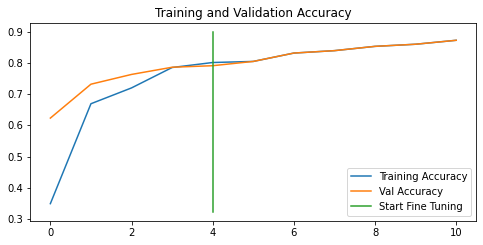

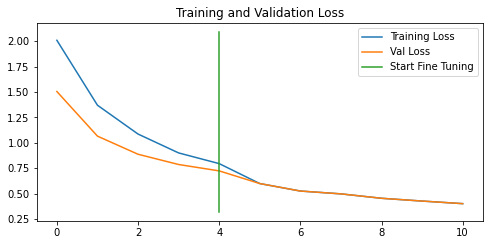

In [ ]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs = 5)

## Viewing our experiment data on TensorBoard

**Note:** Anything you upload to TensorBoard.dev is going to be public.
 So if you have private data, do not upload.


In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should ~4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning." \
  --one_shot # exits the uploader once its finished uploading

My TensorBoard experiments are available at:

In [ ]:

#View all of your uploaded tensorboard.dev experiments
!tensorboard dev list

In [ ]:
# To deete an experiment

!tensorboard dev delete --experiment_id hujkl;'.'